# Enhancing Response Generation with Refined Vector Search

> Our project aims to revolutionize response generation within the realm of natural language processing by leveraging Retrieval-Augmented Generation (RAG) and optimizing vector search techniques. By enhancing the search for vectors most similar to a given query within our Vector DataBase, we seek to elevate the quality and relevance of generated responses. To achieve this, we're employing a sophisticated blend of metaheuristic algorithms alongside graph-based and search algorithms. These methodologies enable us to refine the selection of vectors efficiently, ensuring that the responses generated by our system are not only accurate but also contextually appropriate. Through this innovative approach, we're pushing the boundaries of response generation, paving the way for more advanced and nuanced interactions between humans and AI systems.

![](https://miro.medium.com/v2/resize:fit:828/format:webp/0*WYv0_CaBmCTt7FXc)

In [1]:
%%capture
!pip install llama-index-readers-file pymupdf
!pip install llama-index-embeddings-openai
!mkdir data
!wget --user-agent "Mozilla" "https://arxiv.org/pdf/2307.09288.pdf" -O "data/llama2.pdf"
!pip install -q -U langchain torch sentence-transformers
!pip install hnswlib

In [22]:
from pathlib import Path
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.vector_stores.types import VectorStore
from llama_index.core.vector_stores import (
    VectorStoreQuery,
    VectorStoreQueryResult,
)
from typing import List, Any, Optional, Dict
from llama_index.core.schema import TextNode, BaseNode
import os
from typing import Dict, List, Any, Iterator
from langchain.embeddings import HuggingFaceEmbeddings
from tqdm.auto import tqdm
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import random
import hnswlib
import numpy as np
import random
import math
import time
import torch

In [23]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

> We will extract data from https://arxiv.org/pdf/2307.09288.pdf, which is in PDF format.

In [3]:
loader = PyMuPDFReader()
documents = loader.load(file_path="/content/data/llama2.pdf")

> This code snippet utilizes a SentenceSplitter object with a specified chunk size to break down text into smaller segments. It then calls a method named get_nodes_from_documents on this SentenceSplitter object, passing in a variable containing documents. This process likely aims to divide the documents into manageable sections or nodes, facilitating subsequent text analysis or natural language processing tasks.

In [4]:
node_parser = SentenceSplitter(chunk_size=300)
nodes = node_parser.get_nodes_from_documents(documents)

In [5]:
class BaseVectorStore(VectorStore):
    """Simple custom Vector Store.
    Stores documents in a simple in-memory dict.
    """
    stores_text: bool = True
    def get(self, text_id: str) -> List[float]:
        """Get embedding."""
        pass

    def add(
        self,
        nodes: List[BaseNode],
    ) -> List[str]:
        """Add nodes to index."""
        pass

    def delete(self, ref_doc_id: str, **delete_kwargs: Any) -> None:
        """
        Delete nodes using with ref_doc_id.
        Args:
            ref_doc_id (str): The doc_id of the document to delete.
        """
        pass

    def query(
        self,
        query: VectorStoreQuery,
        **kwargs: Any,
    ) -> VectorStoreQueryResult:
        """Get nodes for response."""
        pass

    def persist(self, persist_path, fs=None) -> None:
        """Persist the SimpleVectorStore to a directory.
        NOTE: we are not implementing this for now.
        """
        pass

In [6]:
class VectorStore2(BaseVectorStore):
    """VectorStore2 (add/get/delete implemented)."""

    stores_text: bool = True

    def __init__(self) -> None:
        """Init params."""
        self.node_dict: Dict[str, BaseNode] = {}

    def get(self, text_id: str) -> List[float]:
        """Get embedding."""
        return self.node_dict[text_id]

    def add(
        self,
        nodes: List[BaseNode],
    ) -> List[str]:
        """Add nodes to index."""
        added_ids = []
        for node in nodes:
            self.node_dict[node.id_] = node
            added_ids.append(node.id_)
        return added_ids

    def delete(self, node_id: str, **delete_kwargs: Any) -> None:
        """
        Delete nodes using with node_id.
        Args:
            node_id: str
        """
        del self.node_dict[node_id]

    def __iter__(self) -> Iterator[BaseNode]:
        """Return iterator over nodes."""
        return iter(self.node_dict.values())

    def __len__(self) -> int:
        """Return the number of nodes in the database."""
        return len(self.node_dict)

    def __getitem__(self, key: str) -> BaseNode:
            """Get item by key."""
            return list(self.node_dict.values())[key]

> We embed the sentence into a vector representation from text data.

In [7]:
modelPath = "sentence-transformers/all-MiniLM-l6-v2"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
                                    model_name=modelPath,
                                    model_kwargs=model_kwargs,
                                    encode_kwargs=encode_kwargs
                                    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

> We create a vector database containing embedding vectors of text data.

In [8]:
vector_store = VectorStore2()
for node in tqdm(nodes):
    embedding_vector = embeddings.embed_query(node.text)
    node.embedding=embedding_vector
    vector_store.add([node])

  0%|          | 0/757 [00:00<?, ?it/s]

In [9]:
class CFG:
    NUM_VECTORS = 15
    class graph:
        taux = 0.5
    class query:
        text="Can you tell me about the key concepts for safety finetuning"
        id="id2"
    class random_walk:
        num_walks=100
    class HNSW:
        M=40
        ef_construction=600
    class Simulated_Annealing :
        VECTOR_DIMENSION = len(vector_store[0].embedding)
        INITIAL_TEMPERATURE = 71
        COOLING_RATE = 0.1
        NUM_ITERATIONS = 10000

# create graph

> We will create a graph where each node is linked with the most similar nodes based on their cosine similarity.

In [10]:
def create_graph(vector_store: VectorStore2) -> nx.Graph:
    graph = nx.Graph()
    node_indices = {node.id_: i for i, node in enumerate(vector_store)}
    num_vectors = len(vector_store)
    similarities = np.zeros((num_vectors, num_vectors))
    for i, node1 in tqdm(enumerate(vector_store),total=num_vectors):
        for j, node2 in enumerate(vector_store):
            if i != j:
                similarities[i, j] = similarities[j, i] = cosine_similarity([node1.embedding], [node2.embedding])[0][0]
    for i, node in tqdm(enumerate(vector_store),total=num_vectors):
        graph.add_node(i, id=node.id_, embedding=node.embedding, text=node.text)
    for i, node1 in tqdm(enumerate(vector_store),total=num_vectors):
        similar_indices = [index for index, v in enumerate(similarities[i]) if v > CFG.graph.taux]
        for j in similar_indices:
            if i != j:
                graph.add_edge(node_indices[node1.id_], node_indices[vector_store[j].id_], weight=similarities[i, j])
    return graph
graph = create_graph(vector_store)

  0%|          | 0/757 [00:00<?, ?it/s]

  0%|          | 0/757 [00:00<?, ?it/s]

  0%|          | 0/757 [00:00<?, ?it/s]

# Query

> We will pose a question (for example: 'Can you tell me about the key concepts for safety fine-tuning?') and search for the best vector similar to this question.

In [27]:
query_node = TextNode(id_=CFG.query.id, text=CFG.query.text)
embedding_query_vector = embeddings.embed_query(query_node.text)
query_node.embedding=embedding_query_vector

# Navigable Small World Graphs

> This algorithm implements a random walk algorithm on a graph to find nodes that are most similar to a given query node based on cosine similarity of their embeddings. The function takes as input a graph representation and a query node. It conducts multiple random walks from different starting points in the graph, calculating cosine similarity between the embeddings of visited nodes and the query node. It iteratively explores neighboring nodes, updating the current node to the most similar neighbor if its similarity exceeds the current best similarity. The process continues until a stopping condition is met. Finally, it returns the top-k most similar nodes along with their similarity scores and the execution time of the algorithm.

![image.png](https://cdn.sanity.io/images/vr8gru94/production/5ca4fca27b2a9bf89b06748b39b7b6238fd4548c-1920x1080.png)

In [66]:
def random_walk(graph, query_node):
    top_k_similar_nodes = {}
    k=CFG.NUM_VECTORS
    num_walks = CFG.random_walk.num_walks
    start_time = time.time()
    for i in tqdm(range(num_walks)):
        set_seed(42*i)
        current_node = random.choice(list(graph.nodes()))
        courrent_similaritie=cosine_similarity([graph.nodes[current_node]['embedding']], [query_node.embedding])[0][0]
        visited_nodes = {}
        visited_nodes[current_node]=courrent_similaritie
        while True:
            neighbors = list(graph.neighbors(current_node))
            if neighbors:
                neighbors_similarities={}
                for node in neighbors:
                    if(node not in visited_nodes.keys()):
                        neighbors_similaritie=cosine_similarity([graph.nodes[node]['embedding']], [query_node.embedding])[0][0]
                        neighbors_similarities[neighbors_similaritie]=node
                if neighbors_similarities!={}:
                    best_neighbors_similaritie=max(neighbors_similarities.keys())
                    if(best_neighbors_similaritie>courrent_similaritie):
                        visited_nodes[neighbors_similarities[best_neighbors_similaritie]]=best_neighbors_similaritie
                        current_node=neighbors_similarities[best_neighbors_similaritie]
                        courrent_similaritie=best_neighbors_similaritie
                    else:
                        break
                else:
                    break
            else:
                break
        sorted_nodes = sorted(visited_nodes.items(), key=lambda x: x[1], reverse=True)
        for node, similarity in sorted_nodes[:k]:
            if node != query_node:
                if node not  in top_k_similar_nodes:
                    top_k_similar_nodes[node] = similarity
    top_k_similar_nodes = sorted(top_k_similar_nodes.items(), key=lambda x: x[1], reverse=True)
    end_time = time.time()
    execution_time = end_time - start_time
    return [(node,similar) for node,similar in top_k_similar_nodes[:k]],execution_time

In [67]:
top_k_similar_nodes,execution_time = random_walk(graph, query_node)
print("similarity_scores:", top_k_similar_nodes)
print("similarity_scores_mean",np.mean([ j for i,j in top_k_similar_nodes]))
print("Execution Time:", execution_time, "seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

similarity_scores: [(254, 0.5223327299740219), (623, 0.5081777139849556), (214, 0.5044199216803499), (206, 0.4834795354842283), (179, 0.4823342516863898), (627, 0.4625600018645752), (212, 0.4577946935789655), (629, 0.4535788064245186), (544, 0.44279080513190283), (210, 0.4398758534593142), (223, 0.43907652949810383), (208, 0.4366955008918973), (13, 0.41768959667458827), (12, 0.41313694544744406), (209, 0.4103037129476686)]
similarity_scores_mean 0.4582831065819283
Execution Time: 10.429403305053711 seconds


# HNSW

> This algorithm implements the Hierarchical Navigable Small World (HNSW) algorithm for approximate nearest neighbor search on a graph. It takes as input the graph representation, the embedding vector of the query, and parameters such as M (the number of bi-directional links created for every new element during construction) and ef_construction (the size of the dynamic list for the nearest neighbors).

> The function first extracts the embeddings of all nodes in the graph and initializes an HNSW index. It then adds these embeddings to the index and conducts a k-nearest neighbor search on the index using the embedding vector of the query. Finally, it returns the labels of the nearest neighbor nodes and the execution time of the algorithm.

![image.png](https://cdn.sanity.io/images/vr8gru94/production/d6e3a660654d9cb55f7ac137a736539e227296b6-1920x1080.png)

In [45]:
def similarity_scores(CFG,selected_vectors,query_vector):
    similarity_scores = [cosine_similarity([graph.nodes[vector]['embedding']],[query_vector])[0][0] for vector in selected_vectors]
    return similarity_scores


def HNSW(CFG, graph, embedding_query_vector, M, ef_construction):
    set_seed(42)
    node_embeddings = {}
    start_time = time.time()
    for node in graph.nodes():
        node_embeddings[node] = graph.nodes[node]['embedding']
    vectors_np = np.array(list(node_embeddings.values()))
    dim = vectors_np.shape[1]
    index = hnswlib.Index(space='l2', dim=dim)
    index.init_index(max_elements=len(vectors_np), ef_construction=ef_construction, M=M)
    index.add_items(vectors_np)
    labels, distances = index.knn_query(embedding_query_vector, k=CFG.NUM_VECTORS)
    end_time = time.time()
    execution_time = end_time - start_time
    return labels, execution_time


def plot_results(results):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Combination Index')
    ax1.set_ylabel('Cosine Similarity', color=color)
    ax1.plot(results['index'], results['cosine_similarity'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Execution Time (seconds)', color=color)
    ax2.plot(results['index'], results['execution_time'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.title('Parameter Exploration')
    plt.show()


def explore_parameters(CFG, graph, embedding_query_vector):
    results = {'index': [], 'M': [], 'ef_construction': [], 'cosine_similarity': [], 'execution_time': []}
    index = 0
    for M in range(5, 50, 5):
        for ef_construction in range(10, 1000, 10):
            labels, execution_time = HNSW(CFG, graph, embedding_query_vector, M, ef_construction)
            distances = similarity_scores(CFG, labels[0], embedding_query_vector)
            cosine_similarity_mean = np.mean(distances)
            results['index'].append(index)
            results['M'].append(M)
            results['ef_construction'].append(ef_construction)
            results['cosine_similarity'].append(cosine_similarity_mean)
            results['execution_time'].append(execution_time)
            index += 1
    return results


def find_best_parameters(results):
    max_similarity_index = np.argmax(results['cosine_similarity'])
    best_parameters = {
        'M': results['M'][max_similarity_index],
        'ef_construction': results['ef_construction'][max_similarity_index],
        'cosine_similarity': results['cosine_similarity'][max_similarity_index],
        'execution_time': results['execution_time'][max_similarity_index]
    }
    return best_parameters

In [30]:
#results = explore_parameters(CFG, graph, embedding_query_vector)
#plot_results(results)

> In this curve, we try many combinations of parameters and calculate the cosine similarity and time for each parameter.

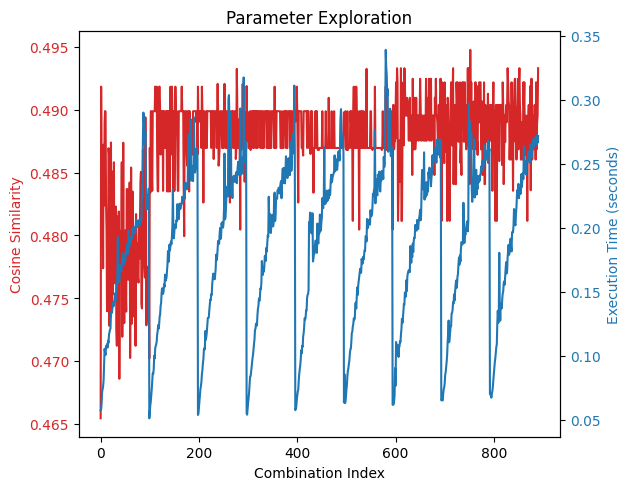]

 Best Parameters:
* M: 40
* ef_construction: 600

In [31]:
#best_params = find_best_parameters(results)
#print("Best Parameters:")
#print("M:", best_params['M'])
#print("ef_construction:", best_params['ef_construction'])
#print("Cosine Similarity:", best_params['cosine_similarity'])
#print("Execution Time:", best_params['execution_time'])

In [56]:
labels,execution_time=HNSW(CFG,graph,embedding_query_vector,CFG.HNSW.M,CFG.HNSW.ef_construction)
distances=similarity_scores(CFG,labels[0],embedding_query_vector)
print("Query results:")
for label, distance in zip(labels[0], distances):
    print(f"Nearest neighbor: {label}, Distance: {distance}")
print("similarity_scores_mean",np.mean(distances))
print("Execution Time:", execution_time, "seconds")

Query results:
Nearest neighbor: 254, Distance: 0.5223327299740219
Nearest neighbor: 623, Distance: 0.5081777139849556
Nearest neighbor: 214, Distance: 0.5044199216803499
Nearest neighbor: 206, Distance: 0.4834795354842283
Nearest neighbor: 179, Distance: 0.4823342516863898
Nearest neighbor: 207, Distance: 0.48133505096419815
Nearest neighbor: 213, Distance: 0.4716673601290764
Nearest neighbor: 222, Distance: 0.47121019499190053
Nearest neighbor: 245, Distance: 0.4697400795645198
Nearest neighbor: 627, Distance: 0.4625600018645752
Nearest neighbor: 212, Distance: 0.4577946935789655
Nearest neighbor: 629, Distance: 0.4535788064245186
Nearest neighbor: 630, Distance: 0.45105347571526866
Nearest neighbor: 89, Distance: 0.44770895343713474
Nearest neighbor: 544, Distance: 0.44279080513190283
similarity_scores_mean 0.47401223830746714
Execution Time: 0.14256644248962402 seconds


# the Simulated Annealing algorithm

> Simulated annealing is an optimization algorithm that iteratively explores and refines solutions to find the optimal solution to a problem. It starts with an initial solution and gradually improves it by making random changes and accepting them based on a probability determined by the current temperature and the difference in solution quality. As the algorithm progresses, the temperature decreases, leading to a more focused search for the optimal solution. Simulated annealing strikes a balance between exploration and exploitation, making it effective for a wide range of optimization tasks.

In [70]:
def similarity_scores(CFG,selected_vectors,query_vector):
    similarity_scores = [cosine_similarity([vector],[query_vector])[0][0] for vector in selected_vectors]
    return similarity_scores


def objective_function(CFG,selected_vectors,query_vector):
    similarity_scores = [cosine_similarity(
                                            [vector],
                                            [query_vector]
                                          )[0][0]
                         for vector in selected_vectors
                        ]
    return np.mean(similarity_scores)


def generate_solution(CFG):
    return random.sample(VDB,
                         CFG.NUM_VECTORS
                        )


def generate_neighbor(CFG,solution):
    neighbor = solution.copy()
    index_to_swap = random.randint(0, CFG.NUM_VECTORS - 1)
    neighbor[index_to_swap] = random.choice(VDB)
    return neighbor


def simulated_annealing(CFG, query_vector, initial_temp, cooling_rate):
    current_solution = generate_solution(CFG)
    current_objective = objective_function(CFG, current_solution, query_vector)
    temperature = initial_temp
    start_time = time.time()
    for _ in tqdm(range(CFG.Simulated_Annealing.NUM_ITERATIONS)):
        neighbor_solution = generate_neighbor(CFG, current_solution)
        neighbor_objective = objective_function(CFG, neighbor_solution, query_vector)
        if neighbor_objective > current_objective or random.uniform(0, 1) < math.exp((neighbor_objective - current_objective) / temperature):
            current_solution = neighbor_solution
            current_objective = neighbor_objective
        temperature *= 1 - cooling_rate
    end_time = time.time()
    execution_time = end_time - start_time
    return current_solution, execution_time


def explore_parameters_sa(CFG, query_vector):
    results = {'index': [], 'INITIAL_TEMPERATURE': [], 'COOLING_RATE': [], 'cosine_similarity': [], 'execution_time': []}
    index = 0
    for initial_temp in range(1, 100, 10):
        for cooling_rate in [0.001, 0.01, 0.1]:
            best_solution, execution_time = simulated_annealing(CFG, query_vector, initial_temp, cooling_rate)
            scores = similarity_scores(CFG, best_solution, query_vector)
            cosine_similarity_mean = np.mean(scores)
            results['index'].append(index)
            results['INITIAL_TEMPERATURE'].append(initial_temp)
            results['COOLING_RATE'].append(cooling_rate)
            results['cosine_similarity'].append(cosine_similarity_mean)
            results['execution_time'].append(execution_time)
            index += 1
    return results


def find_best_parameters_sa(results):
    max_similarity_index = np.argmax(results['cosine_similarity'])
    best_parameters = {
        'INITIAL_TEMPERATURE': results['INITIAL_TEMPERATURE'][max_similarity_index],
        'COOLING_RATE': results['COOLING_RATE'][max_similarity_index],
        'cosine_similarity': results['cosine_similarity'][max_similarity_index],
        'execution_time': results['execution_time'][max_similarity_index]
    }
    return best_parameters

In [19]:
#results_sa = explore_parameters_sa(CFG, embedding_query_vector)
#best_params_sa = find_best_parameters_sa(results_sa)
#print("Best Parameters for Simulated Annealing:")
#print("INITIAL_TEMPERATURE:", best_params_sa['INITIAL_TEMPERATURE'])
#print("COOLING_RATE:", best_params_sa['COOLING_RATE'])
#print("Cosine Similarity:", best_params_sa['cosine_similarity'])
#print("Execution Time:", best_params_sa['execution_time'])

best_params:
* INITIAL_TEMPERATURE: 71
* COOLING_RATE: 0.1

In [73]:
%%capture
set_seed(42)
VDB = [graph.nodes[node]['embedding'] for node in graph.nodes()]
NUM_VECTORS = CFG.NUM_VECTORS
VECTOR_DIMENSION = CFG.Simulated_Annealing.VECTOR_DIMENSION
INITIAL_TEMPERATURE = CFG.Simulated_Annealing.INITIAL_TEMPERATURE
COOLING_RATE = CFG.Simulated_Annealing.COOLING_RATE
NUM_ITERATIONS = CFG.Simulated_Annealing.NUM_ITERATIONS
best_solution,execution_time = simulated_annealing(CFG,embedding_query_vector,INITIAL_TEMPERATURE,COOLING_RATE)
scores=similarity_scores(CFG,best_solution,embedding_query_vector)

In [74]:
print("Objective Value:", objective_function(CFG,best_solution,embedding_query_vector))
print("similarity_scores:", scores)
print("similarity_scores_mean",np.mean(scores))
print("Execution Time:", execution_time, "seconds")

Objective Value: 0.5176046620558532
similarity_scores: [0.5223327299740219, 0.5223327299740219, 0.5223327299740219, 0.5223327299740219, 0.5223327299740219, 0.5223327299740219, 0.5223327299740219, 0.5044199216803499, 0.5223327299740219, 0.5081777139849556, 0.5223327299740219, 0.5223327299740219, 0.4834795354842283, 0.5223327299740219, 0.5223327299740219]
similarity_scores_mean 0.5176046620558532
Execution Time: 58.538307905197144 seconds


# Summary

With n_vectors = 743

\begin{array}{|c|c|c|}
\hline
 & \text{Mean of similarity scores} & \text{Execution Time} \\
\hline
\text{Navigable Small World Graphs} & \text{0.458} & \text{11.74} \\
\text{Hierarchical Navigable Small Worlds} & \text{0.474} & \text{0.142} \\
\text{Simulated Annealing} & \text{0.497} & \text{57.8}\\
\hline
\end{array}

With n_vectors = 1404

\begin{array}{|c|c|c|}
\hline
 & \text{Mean of similarity scores} & \text{Execution Time} \\
\hline
\text{Navigable Small World Graphs} & \text{0.486} & \text{18.29} \\
\text{Hierarchical Navigable Small Worlds} & \text{0.494} & \text{0.22} \\
\text{Simulated Annealing} & \text{0.51} & \text{61.04}\\
\hline
\end{array}

With n_vectors = 2175

\begin{array}{|c|c|c|}
\hline
 & \text{Mean of similarity scores} & \text{Execution Time} \\
\hline
\text{Navigable Small World Graphs} & \text{0.497} & \text{25.39} \\
\text{Hierarchical Navigable Small Worlds} & \text{0.499} & \text{0.408} \\
\text{Simulated Annealing} & \text{0.5258} & \text{61,4}\\
\hline
\end{array}
